# Global Use

#### Requirements

In [85]:
# venv downlaods
!python3 -m pip install --upgrade pip
!python3 -m pip install -U numpy scikit-learn seaborn matplotlib scikit-fuzzy

#### Libs

In [86]:
# Standard libraries
import os
import time

# Data processing
import numpy as np
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering
import skfuzzy as fuzz
from skfuzzy.cluster import cmeans, cmeans_predict
from sklearn.cluster import KMeans

## Functions

### Load Data

In [87]:
# === Data Reading Utilities ===

def read_attr_file(attr_path: str) -> list[str]:
    """
    Read attribute file where each line is a single attribute name.
    Returns:
        List of attribute names as strings.
    """
    with open(attr_path, 'r') as f:
        return [line.strip() for line in f]

def read_data_file(data_path: str) -> list[list[float]]:
    """
    Reads a .data file where each line contains space- or tab-separated numeric values.

    Returns:
        List of rows, each a list of floats.
    """
    with open(data_path, 'r') as f:
        return [list(map(float, line.strip().split())) for line in f]

In [88]:
# === Matrix Utiliti ===

def build_dataset_matrix(
    all_attrs: list[str],
    full_data_list: list[list[float]],
    nr_values_to_visualize: int = 10,
    shuffle: bool = False
) -> tuple[np.ndarray, dict[str, int]]:
    """
    Converts list-of-lists into a NumPy matrix and attribute index mapping.

    Args:
        all_attrs: List of attribute names.
        full_data_list: List of rows, each a list of floats.
        nr_values_to_visualize: Number of top rows to randomize for diversity.
        shuffle: Whether to shuffle the top rows.

    Returns:
        data_mat: NumPy array (samples x attributes)
        attr_idx: Mapping of attribute name to column index
    """
    n, m = len(full_data_list), len(all_attrs)
    data_mat = np.full((n, m), np.nan, dtype=np.float64)

    for i, row in enumerate(full_data_list):
        for j, val in enumerate(row):
            if j < m:
                data_mat[i, j] = val

    idx = {attr: i for i, attr in enumerate(all_attrs)}

    if shuffle and n > nr_values_to_visualize:
        rng = np.random.default_rng(42)
        swap_indices = rng.choice(np.arange(nr_values_to_visualize, n), size=nr_values_to_visualize, replace=False)
        for i, j in enumerate(swap_indices):
            data_mat[[i, j]] = data_mat[[j, i]]

    return data_mat, idx

In [89]:
# === Folder Utiliti ===

def load_folder_data(base_dir: str, folder: str):
    """
    Loads data from subfolders that contain .attr and .data files.

    Each subfolder (e.g., /data/male/1/) should contain exactly one .attr and one .data file.

    Args:
        base_dir: Root directory (e.g., 'data')
        folder: Subdirectory under base_dir (e.g., 'male')

    Yields:
        Tuple (subfolder_name, data_list, attr_list)
    """
    full_folder_path = os.path.join(base_dir, folder)

    for subfolder in sorted(os.listdir(full_folder_path)):
        subfolder_path = os.path.join(full_folder_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue

        # Search for .attr and .data files
        attr_file = None
        data_file = None
        for filename in os.listdir(subfolder_path):
            if filename.endswith(".attr"):
                attr_file = os.path.join(subfolder_path, filename)
            elif filename.endswith(".data"):
                data_file = os.path.join(subfolder_path, filename)

        if not attr_file or not data_file:
            print(f"Skipping {subfolder}: missing .attr or .data file")
            continue

        attr_list = read_attr_file(attr_file)
        data_list = read_data_file(data_file)
        yield subfolder, data_list, attr_list


### Data Visualization

In [90]:
def mask_random_values(data: np.ndarray, mask_ratio: float = 0.1, seed: int | None = None) -> np.ndarray:
    """
    Randomly masks non-NaN values in the matrix.

    Args:
        data: Input data array (may contain NaNs).
        mask_ratio: Fraction of known values to mask.
        seed: Optional random seed for reproducibility. If None, uses system entropy.

    Returns:
        A masked copy of the data with NaNs introduced.
    """
    rng = np.random.default_rng(seed)  # deterministic if seed is set, random otherwise
    data_copy = data.copy()

    mask = ~np.isnan(data_copy)
    indices = np.argwhere(mask)
    rng.shuffle(indices)

    n_mask = int(mask_ratio * len(indices))
    for i, j in indices[:n_mask]:
        data_copy[i, j] = np.nan

    return data_copy

In [91]:
def plot_imputation_comparison(original: np.ndarray, filled: np.ndarray, max_rows: int = 20, seed: int = 42):
    """
    Plots side-by-side heatmaps of masked and filled data with numeric values,
    in real time. If data has more than 50 rows, randomly selects 50.

    Args:
        original: Original data with NaNs (masked).
        filled: Imputed data.
        max_rows: Number of rows to print (not used in plot anymore).
        seed: Random seed for reproducibility.
    """
    
    n_rows = original.shape[0]
    display_rows = min(n_rows, 50)

    if n_rows > 50:
        rng = np.random.default_rng(seed)
        indices = rng.choice(n_rows, size=display_rows, replace=False)
        original = original[indices]
        filled = filled[indices]

    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    for ax, matrix, title in zip(axes, [original, filled], ["Original (masked)", "After Imputation"]):
        sns.heatmap(
            matrix,
            ax=ax,
            annot=True,
            fmt=".2f",
            cmap="viridis",
            cbar=True,
            mask=np.isnan(matrix) if title == "Original (masked)" else None
        )
        ax.set_title(title)
        ax.set_xlabel("Attributes")
        ax.set_ylabel("Samples")

    plt.tight_layout()
    plt.show()


In [92]:
def visualize_clusters(data: np.ndarray, u_matrix: np.ndarray):
    """
    Visualizes soft clusters from FCM by reducing data to 2D using PCA.

    Args:
        data: Original data matrix (samples x features)
        u_matrix: Membership matrix from FCM (clusters x samples)
    """
    if data.shape[0] != u_matrix.shape[1]:
        raise ValueError("Mismatch between data rows and membership matrix samples")

    pca = PCA(n_components=2)
    reduced = pca.fit_transform(data)
    cluster_ids = np.argmax(u_matrix, axis=0)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=cluster_ids, palette="Set2", legend='full')

    plt.title("Cluster Visualization (PCA Projection)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# K najblizszych sasiadow | baseline

## KNN-related methods

In [93]:
def fill_missing_knn(data: np.ndarray, k: int = 5, verbose: bool = False) -> np.ndarray:
    """
    Fills missing values using KNN while preserving original shape.
    Any all-NaN columns are restored as NaN after imputation.
    """
    if verbose:
        print(f"Missing before KNN: {np.isnan(data).sum()}")

    original_shape = data.shape
    all_nan_columns = np.isnan(data).all(axis=0)
    valid_cols = ~all_nan_columns

    imputer = KNNImputer(n_neighbors=k, weights="uniform", metric="nan_euclidean")
    partial_filled = imputer.fit_transform(data[:, valid_cols])

    filled = np.full(original_shape, np.nan)
    filled[:, valid_cols] = partial_filled

    if verbose:
        print(f"Missing after KNN: {np.isnan(filled).sum()}")

    return filled

## Main code


Loaded subfolder: 1
Missing before KNN: 13593
Missing after KNN: 7552


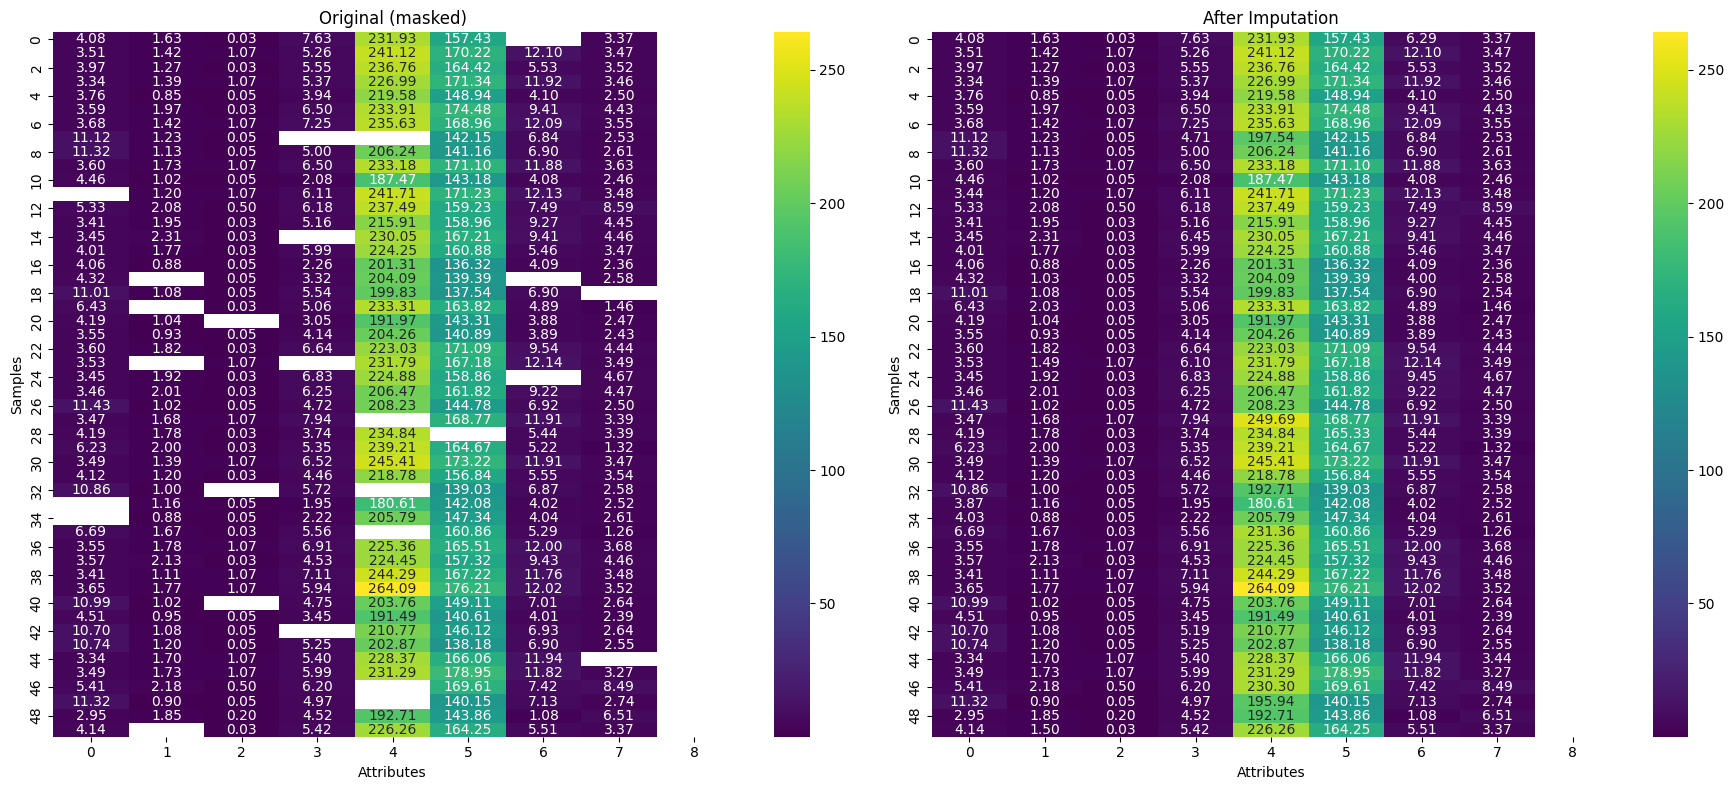


First 10 filled rows (KNN):
Row 0: {'0': 3.2048, '1': 2.2230, '2': 0.1993, '4': 6.4552, '7': 184.2030, '9': 139.9670, '11': 1.0442, '12': 6.5256, '14': nan}
Row 1: {'0': 6.7904, '1': 1.9666, '2': 0.0259, '4': 4.1634, '7': 212.8150, '9': 165.0390, '11': 5.0268, '12': 1.3143, '14': nan}
Row 2: {'0': 11.6872, '1': 1.0310, '2': 0.0496, '4': 5.3930, '7': 212.9180, '9': 132.1300, '11': 6.9670, '12': 2.5649, '14': nan}
Row 3: {'0': 3.4167, '1': 2.0548, '2': 0.0275, '4': 6.0224, '7': 233.7460, '9': 156.7690, '11': 9.3862, '12': 4.6047, '14': nan}
Row 4: {'0': 6.6121, '1': 1.7028, '2': 0.0321, '4': 4.4683, '7': 224.0450, '9': 160.8032, '11': 5.0297, '12': 1.4585, '14': nan}
Row 5: {'0': 2.9483, '1': 2.8301, '2': 0.2006, '4': 4.3296, '7': 188.8190, '9': 134.4180, '11': 1.0465, '12': 6.4318, '14': nan}
Row 6: {'0': 3.1772, '1': 1.9693, '2': 0.2001, '4': 7.0474, '7': 185.3120, '9': 151.6720, '11': 0.8938, '12': 6.4677, '14': nan}
Row 7: {'0': 6.5493, '1': 1.9616, '2': 0.0276, '4': 5.4848, '7': 22

In [94]:
def knn_main(
    base_dir: str = "dane",
    folder: str = "duze",
    k: int = 5,
    mask_ratio: float = 0.1,
    n_rows_to_show: int = 10,
    verbose: bool = True,
    plot: bool = True,
    seed: int = 42
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Executes KNN-only imputation on the first dataset found in the folder.

    Returns:
        - original_data: full dataset before masking
        - masked_data: dataset with NaNs introduced
        - filled_data: imputed dataset using KNN
    """
    for subfolder, full_data_list, all_attrs in load_folder_data(base_dir, folder):
        if verbose:
            print(f"\nLoaded subfolder: {subfolder}")

        data_mat, attr_idx = build_dataset_matrix(
            all_attrs, full_data_list,
            nr_values_to_visualize=n_rows_to_show,
            shuffle=False
        )

        #data_mat = remove_all_nan_rows(data_mat)

        masked = mask_random_values(data_mat, mask_ratio=mask_ratio, seed=seed)
        filled = fill_missing_knn(masked, k=k, verbose=verbose)

        if plot:
            plot_imputation_comparison(masked, filled, max_rows=n_rows_to_show)

        if verbose:
            sorted_attrs = sorted(attr_idx.keys(), key=int)
            print(f"\nFirst {n_rows_to_show} filled rows (KNN):")
            for i in range(min(n_rows_to_show, filled.shape[0])):
                row_repr = ", ".join(
                    f"'{a}': {filled[i, attr_idx[a]]:.4f}"
                    for a in sorted_attrs if attr_idx[a] < filled.shape[1]
                )
                print(f"Row {i}: {{{row_repr}}}")

        return data_mat, masked, filled

    raise ValueError(f"No datasets found in '{base_dir}/{folder}'")

original, masked, knn_filled = knn_main(
    base_dir="dane",
    folder="duze",
    k=5,
    mask_ratio=0.1,
    plot=True,
    verbose=True,
    seed=42
)


## Benchmark KNN

Running knn_main(k=1, seed=101)...
Running knn_main(k=1, seed=202)...
Running knn_main(k=1, seed=303)...
k = 1: avg = 1.03s, std = 0.01s
Running knn_main(k=2, seed=101)...
Running knn_main(k=2, seed=202)...
Running knn_main(k=2, seed=303)...
k = 2: avg = 1.03s, std = 0.00s
Running knn_main(k=3, seed=101)...
Running knn_main(k=3, seed=202)...
Running knn_main(k=3, seed=303)...
k = 3: avg = 1.07s, std = 0.04s
Running knn_main(k=4, seed=101)...
Running knn_main(k=4, seed=202)...
Running knn_main(k=4, seed=303)...
k = 4: avg = 1.06s, std = 0.01s
Running knn_main(k=5, seed=101)...
Running knn_main(k=5, seed=202)...
Running knn_main(k=5, seed=303)...
k = 5: avg = 1.12s, std = 0.08s
Running knn_main(k=6, seed=101)...
Running knn_main(k=6, seed=202)...
Running knn_main(k=6, seed=303)...
k = 6: avg = 1.13s, std = 0.04s
Running knn_main(k=7, seed=101)...
Running knn_main(k=7, seed=202)...
Running knn_main(k=7, seed=303)...
k = 7: avg = 1.14s, std = 0.02s
Running knn_main(k=8, seed=101)...
Runnin

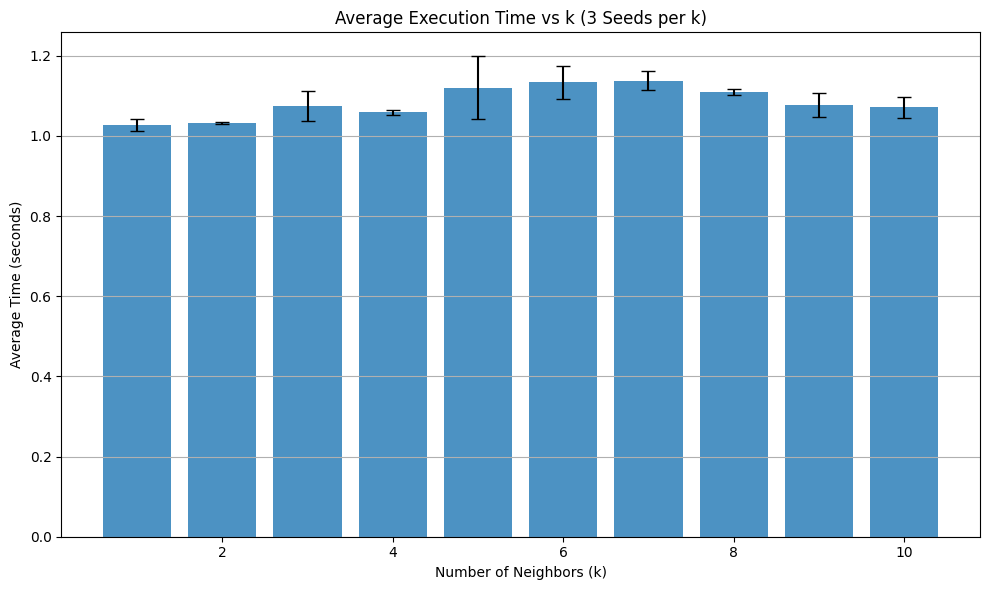

In [95]:
def benchmark_knn_main_over_k_multi_seed(
    ks: list[int] = list(range(1, 11)),  # k = 1 to 10
    seeds: list[int] = [101, 202, 303],
    folder: str = "duze"
):
    """
    Benchmarks knn_main for multiple k values and seeds. Averages over seeds.
    Displays results in a bar chart.
    """
    results = []
    all_std = []

    for k in ks:
        durations = []

        for seed in seeds:
            print(f"Running knn_main(k={k}, seed={seed})...")
            start = time.perf_counter()
            knn_main(base_dir="dane", folder=folder, k=k, verbose=False, plot=False, seed=seed)
            end = time.perf_counter()
            duration = end - start
            durations.append(duration)

        avg_time = np.mean(durations)
        std_dev = np.std(durations)
        results.append(avg_time)
        all_std.append(std_dev)
        print(f"k = {k}: avg = {avg_time:.2f}s, std = {std_dev:.2f}s")

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.bar(ks, results, yerr=all_std, capsize=5, alpha=0.8)
    plt.title("Average Execution Time vs k (3 Seeds per k)")
    plt.xlabel("Number of Neighbors (k)")
    plt.ylabel("Average Time (seconds)")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    return list(zip(ks, results, all_std))

knn_results = benchmark_knn_main_over_k_multi_seed()


# FCM | t.1

## FCM-related methods

In [96]:
def preprocess_with_fcm(data: np.ndarray, n_clusters: int = 3):
    """
    Applies mean imputation and FCM clustering.

    Returns:
        clustered_data: mean-filled matrix (for clustering)
        u_matrix: soft cluster membership matrix
        hard_clusters: hard cluster assignments (argmax of u_matrix)
    """
    from sklearn.impute import SimpleImputer
    from skfuzzy.cluster import cmeans

    simple_imputer = SimpleImputer(strategy="mean")
    clustered_data = simple_imputer.fit_transform(data)

    transposed = clustered_data.T
    cntr, u, _, _, _, _, _ = cmeans(transposed, c=n_clusters, m=2, error=0.005, maxiter=1000)
    hard_clusters = np.argmax(u, axis=0)
    return clustered_data, u, hard_clusters

## Main Code (FCM Only)


Processing folder: 1
Dataset shape: 7552 samples × 9 attributes


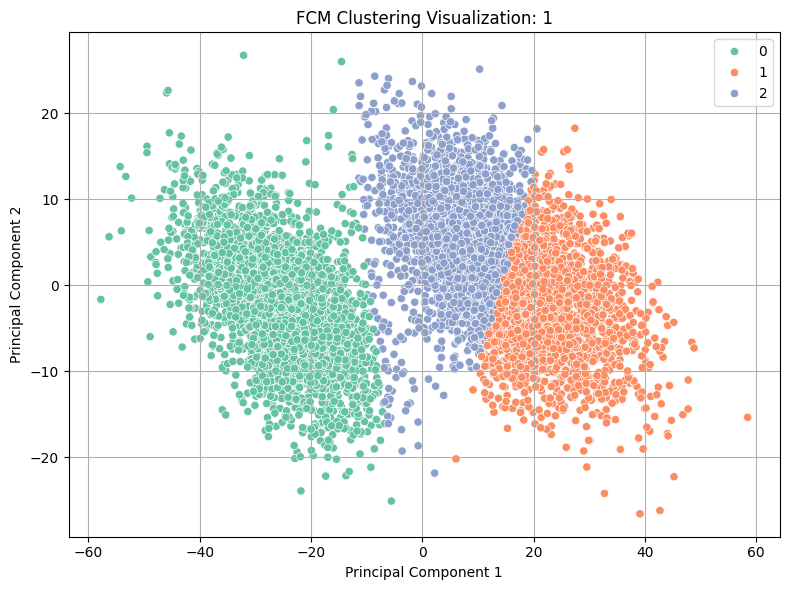

First 10 filled rows:
Row 0: {'0': 3.2048, '1': 2.2230, '2': 0.2021, '4': 6.4552, '7': 184.2030, '9': 140.8250, '11': 1.0442, '12': 6.5256}
Row 1: {'0': 6.7904, '1': 1.9666, '2': 0.0259, '4': 4.1634, '7': 212.8150, '9': 165.0390, '11': 5.0268, '12': 1.3143}
Row 2: {'0': 11.6872, '1': 1.0310, '2': 0.0496, '4': 5.3930, '7': 212.9180, '9': 132.1300, '11': 7.0364, '12': 2.5649}
Row 3: {'0': 3.4167, '1': 2.0548, '2': 0.0275, '4': 6.0224, '7': 233.7460, '9': 156.7690, '11': 9.3862, '12': 4.6047}
Row 4: {'0': 6.6121, '1': 1.7028, '2': 0.0321, '4': 4.4683, '7': 224.0450, '9': 160.2610, '11': 5.0297, '12': 1.4585}
Row 5: {'0': 2.9483, '1': 2.8301, '2': 0.2006, '4': 4.3296, '7': 188.8190, '9': 134.4180, '11': 1.0465, '12': 6.4318}
Row 6: {'0': 3.1772, '1': 1.9693, '2': 0.2001, '4': 7.0474, '7': 185.3120, '9': 151.6720, '11': 0.8938, '12': 6.4677}
Row 7: {'0': 6.5493, '1': 1.9616, '2': 0.0276, '4': 5.4848, '7': 226.6640, '9': 165.1570, '11': 5.0927, '12': 1.2146}
Row 8: {'0': 4.2938, '1': 0.9268,

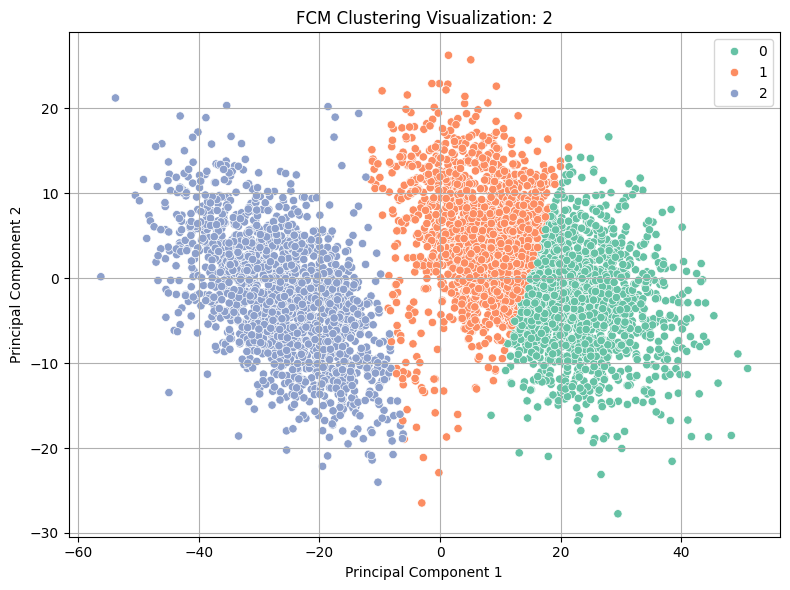

First 10 filled rows:
Row 0: {'0': 3.6630, '1': 2.3628, '2': 0.0510, '4': 3.3196, '7': 235.3020, '9': 161.6850, '11': 4.6498, '12': 2.4687}
Row 1: {'0': 3.9446, '1': 0.8851, '2': 0.0494, '4': 2.8035, '7': 188.8960, '9': 139.4850, '11': 4.0118, '12': 2.5023}
Row 2: {'0': 3.1617, '1': 1.2504, '2': 0.0320, '4': 6.1601, '7': 214.8670, '9': 168.4660, '11': 4.6892, '12': 2.3827}
Row 3: {'0': 3.4853, '1': 1.3963, '2': 0.0712, '4': 6.3602, '7': 230.6790, '9': 175.2940, '11': 4.9489, '12': 3.6275}
Row 4: {'0': 3.3710, '1': 2.0920, '2': 0.0312, '4': 7.7848, '7': 218.2790, '9': 165.5560, '11': 5.1546, '12': 2.4234}
Row 5: {'0': 3.4657, '1': 1.5635, '2': 0.0685, '4': 4.8010, '7': 229.7590, '9': 161.5690, '11': 5.1374, '12': 3.5563}
Row 6: {'0': 4.0056, '1': 1.0965, '2': 0.0538, '4': 5.5998, '7': 204.0360, '9': 136.8710, '11': 4.0102, '12': 2.6080}
Row 7: {'0': 4.2218, '1': 1.4268, '2': 0.0302, '4': 6.0523, '7': 223.6330, '9': 169.3950, '11': 4.3974, '12': 2.5356}
Row 8: {'0': 3.4942, '1': 1.2573, 

In [97]:
def fcm_main(
    base_dir: str = "dane",
    folder: str = "duze",
    n_clusters: int = 3,
    n_rows_to_show: int = 10,
    verbose: bool = True
):
    """
    Loads datasets, applies FCM clustering with mean imputation, and visualizes the results.

    Args:
        base_dir: Root data folder.
        folder: Subfolder with source directories.
        n_clusters: Number of fuzzy clusters to apply.
        n_rows_to_show: Number of filled rows to print for preview.
        verbose: Print detailed output if True.
    """
    for subfolder, full_data_list, all_attrs in load_folder_data(base_dir, folder):
        if verbose:
            print(f"\nProcessing folder: {subfolder}")
            print(f"Dataset shape: {len(full_data_list)} samples × {len(all_attrs)} attributes")

        data_mat, attr_idx = build_dataset_matrix(
            all_attrs, full_data_list,
            nr_values_to_visualize=n_rows_to_show,
            shuffle=False
        )

        # FCM clustering with shared logic
        clustered_data, u_matrix, hard_clusters = preprocess_with_fcm(data_mat, n_clusters=n_clusters)

        # Visualize cluster memberships using PCA
        reduced = PCA(n_components=2).fit_transform(clustered_data)
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=hard_clusters, palette="Set2", legend="full")
        plt.title(f"FCM Clustering Visualization: {subfolder}")
        plt.xlabel("Principal Component 1")
        plt.ylabel("Principal Component 2")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        plt.pause(0.01)

        # Print a preview of imputed values used for clustering
        if verbose:
            sorted_attrs = sorted(attr_idx.keys(), key=int)
            print(f"First {n_rows_to_show} filled rows:")
            for i in range(min(n_rows_to_show, clustered_data.shape[0])):
                row_repr = ", ".join(
                    f"'{a}': {clustered_data[i, attr_idx[a]]:.4f}"
                    for a in sorted_attrs if attr_idx[a] < clustered_data.shape[1]
                )
                print(f"Row {i}: {{{row_repr}}}")

fcm_main()

# FCM+KNN-Related methods

In [98]:
def visualize_clusters_XD(data: np.ndarray, u_matrix: np.ndarray):
    """
    Visualizes FCM soft clusters via PCA.

    Args:
        data: 2D array with no NaNs.
        u_matrix: Cluster membership matrix (clusters x samples).
    """
    if data.shape[0] != u_matrix.shape[1]:
        raise ValueError("Shape mismatch: data rows and membership matrix")

    cluster_ids = np.argmax(u_matrix, axis=0)
    reduced = PCA(n_components=2).fit_transform(data)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=cluster_ids, palette="Set2", legend="full")
    plt.title("FCM Cluster Visualization")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [99]:
def impute_by_fcm_knn(masked: np.ndarray, n_clusters: int, k: int) -> tuple[np.ndarray, np.ndarray]:
    """
    Clusters the masked data with FCM and imputes missing values using KNN per cluster.

    Returns:
        - filled: final imputed data
        - hard_clusters: array of cluster assignments
    """
    n_samples, n_features = masked.shape
    filled = np.empty_like(masked)

    clustered_data, _, hard_clusters = preprocess_with_fcm(masked, n_clusters=n_clusters)
    imputer = KNNImputer(n_neighbors=k, weights="uniform", metric="nan_euclidean")

    for cluster_id in range(n_clusters):
        cluster_mask = hard_clusters == cluster_id
        cluster_data = masked[cluster_mask]

        if cluster_data.shape[0] == 0 or np.isnan(cluster_data).all(axis=1).any():
            continue

        try:
            filled_cluster = imputer.fit_transform(cluster_data)

            if filled_cluster.shape[1] != n_features:
                pad = n_features - filled_cluster.shape[1]
                filled_cluster = np.pad(filled_cluster, ((0, 0), (0, pad)), constant_values=np.nan)

            filled[cluster_mask] = filled_cluster
        except Exception as e:
            print(f"Cluster {cluster_id} failed: {e}")
            fallback = SimpleImputer(strategy="mean").fit_transform(cluster_data)
            filled[cluster_mask] = fallback

    return filled, hard_clusters

In [100]:
def visualize_cluster_result(filled: np.ndarray, hard_clusters: np.ndarray, subfolder: str):
    """
    Runs PCA and visualizes cluster assignments.
    """
    if np.isnan(filled).any():
        filled = SimpleImputer(strategy="mean").fit_transform(filled)

    reduced = PCA(n_components=2).fit_transform(filled)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=hard_clusters, palette="Set2", legend="full")
    plt.title(f"Post-Imputation FCM Cluster Visualization: {subfolder}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.pause(0.01)

## Main code for FcmKnn | t.2

In [101]:
def knn_fcm_main(
    base_dir: str = "dane",
    folder: str = "duze",
    k: int = 5,
    n_clusters: int = 8,
    mask_ratio: float = 0.1,
    n_rows_to_show: int = 10,
    verbose: bool = True,
    visualize: bool = False,
    seed: int = 42,
    external_masked: np.ndarray | None = None
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Applies FCM+KNN imputation using optional shared masked data.
    Returns:
        original_data, masked_data, filled_data (all np.ndarrays)
    """
    for subfolder, full_data_list, all_attrs in load_folder_data(base_dir, folder):
        if verbose:
            print(f"\nProcessing: {subfolder}")

        data_mat, attr_idx = build_dataset_matrix(
            all_attrs, full_data_list,
            nr_values_to_visualize=n_rows_to_show,
            shuffle=False
        )

        # Use external masked version if provided
        if external_masked is not None:
            masked = external_masked.copy()
        else:
            masked = mask_random_values(data_mat, mask_ratio=mask_ratio, seed=seed)

        filled, hard_clusters = impute_by_fcm_knn(masked, n_clusters=n_clusters, k=k)

        if visualize:
            visualize_cluster_result(filled, hard_clusters, subfolder)
            plot_imputation_comparison(masked, filled, max_rows=n_rows_to_show)

        if verbose:
            sorted_attrs = sorted(attr_idx.keys(), key=int)
            print(f"First {n_rows_to_show} filled rows:")
            for i in range(min(n_rows_to_show, filled.shape[0])):
                row_repr = ", ".join(
                    f"'{a}': {filled[i, attr_idx[a]]:.4f}"
                    for a in sorted_attrs if attr_idx[a] < filled.shape[1]
                )
                print(f"Row {i}: {{{row_repr}}}")

        return data_mat, masked, filled  # Return first processed set

    raise ValueError(f"No datasets found in '{base_dir}/{folder}'")

_, _, fcm_filled = knn_fcm_main(seed=42, visualize=False, verbose=False, external_masked=masked)


# Grupowanie na L

In [102]:
def final_grouping_kmeans(filled_blocks: list[np.ndarray], n_clusters: int = 5, visualize: bool = True):
    """
    Combines imputed datasets and applies KMeans clustering.

    Args:
        filled_blocks: List of imputed arrays.
        n_clusters: Number of final clusters.
        visualize: Whether to show PCA plot.

    Returns:
        Tuple of (labels, full dataset).
    """
    combined = np.vstack(filled_blocks)

    # Fill any leftover NaNs
    if np.isnan(combined).any():
        print("Filling remaining NaNs with column means before clustering...")
        combined = SimpleImputer(strategy="mean").fit_transform(combined)

    # Final clustering
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto')
    labels = kmeans.fit_predict(combined)

    if visualize:
        reduced = PCA(n_components=2).fit_transform(combined)
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=labels, palette="Set1")
        plt.title(f"Final Grouping into {n_clusters} Clusters")
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return labels, combined

In [103]:
def run_full_fcm_knn_pipeline(
    base_dir: str = "dane",
    folder: str = "duze",
    k: int = 5,
    fcm_clusters: int = 8,
    final_clusters: int = 5,
    mask_ratio: float = 0.1,
    n_rows_to_show: int = 10,
    verbose: bool = True,
    visualize: bool = True
):
    """
    Runs knn_fcm_main and then applies final grouping to the filled results.
    """
    filled_blocks = knn_fcm_main(
        base_dir=base_dir,
        folder=folder,
        k=k,
        n_clusters=fcm_clusters,
        mask_ratio=mask_ratio,
        n_rows_to_show=n_rows_to_show,
        verbose=verbose,
        visualize=visualize
    )

    labels, combined = final_grouping_kmeans(filled_blocks, n_clusters=final_clusters, visualize=visualize)
    return labels, combined


Processing: 1


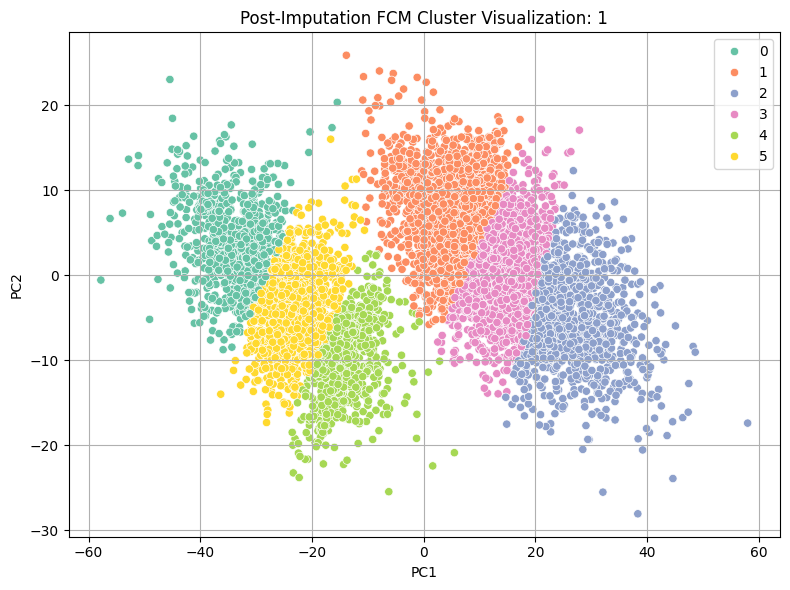

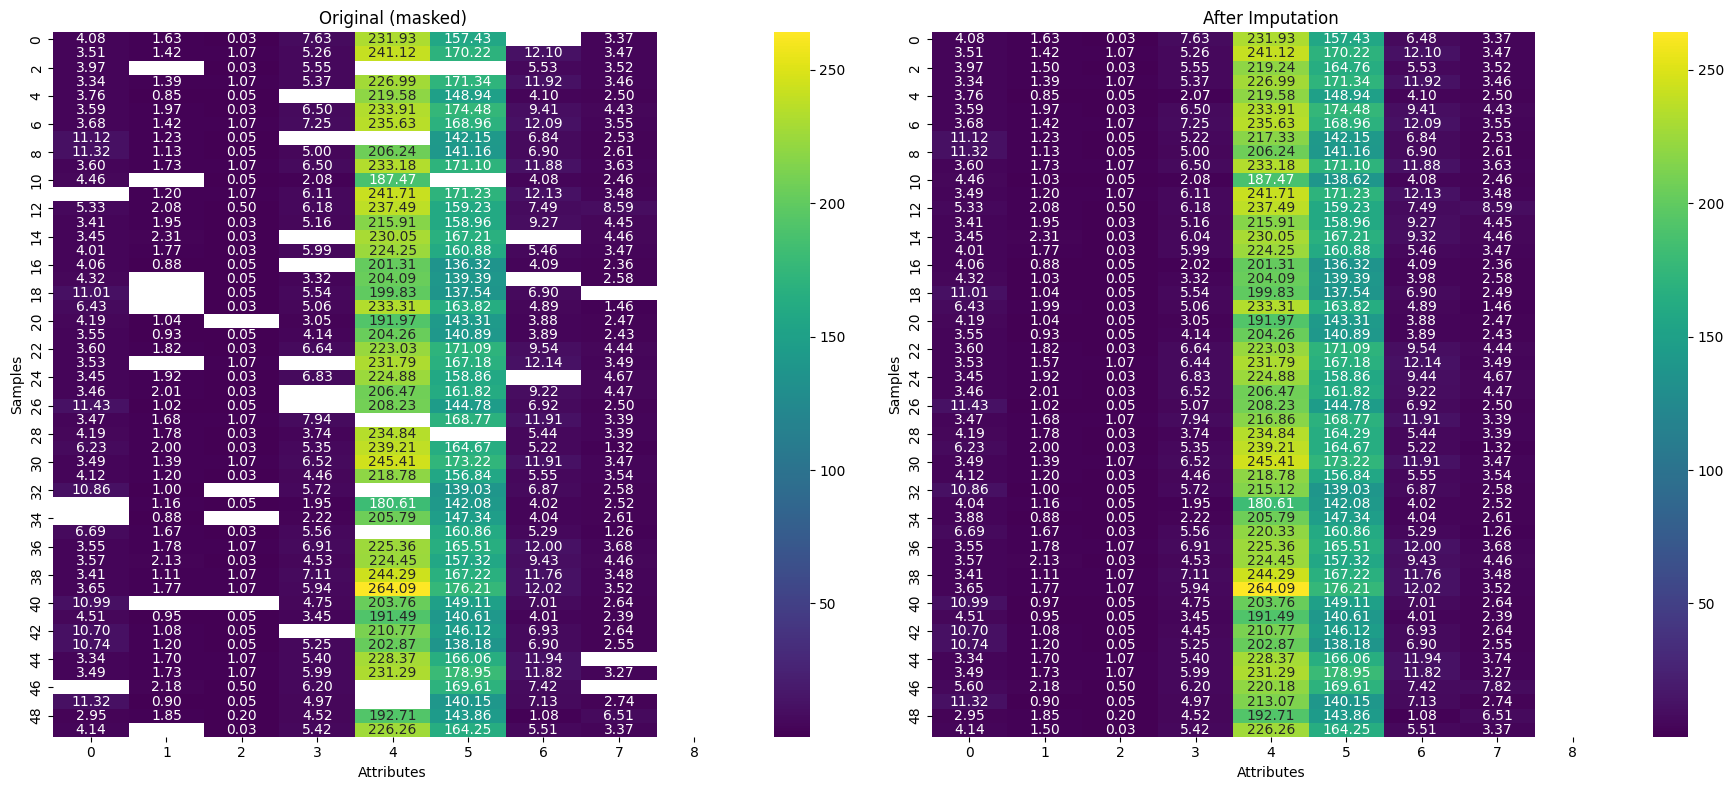

First 10 filled rows:
Row 0: {'0': 3.2048, '1': 2.2230, '2': 0.1998, '4': 5.4459, '7': 184.2030, '9': 139.9355, '11': 1.0442, '12': 6.5256, '14': nan}
Row 1: {'0': 6.7904, '1': 1.9666, '2': 0.0259, '4': 4.1634, '7': 218.6524, '9': 165.0390, '11': 5.0268, '12': 1.3143, '14': nan}
Row 2: {'0': 11.6872, '1': 1.0310, '2': 0.0496, '4': 5.3930, '7': 214.4629, '9': 132.1300, '11': 6.7316, '12': 2.5649, '14': nan}
Row 3: {'0': 3.4167, '1': 2.0548, '2': 0.0275, '4': 6.0224, '7': 233.7460, '9': 156.7690, '11': 9.3862, '12': 4.6047, '14': nan}
Row 4: {'0': 6.6121, '1': 1.7028, '2': 0.0321, '4': 4.4683, '7': 224.0450, '9': 167.3325, '11': 5.0297, '12': 1.4585, '14': nan}
Row 5: {'0': 2.9483, '1': 2.8301, '2': 0.2006, '4': 4.3296, '7': 188.8190, '9': 134.4180, '11': 1.0465, '12': 6.4318, '14': nan}
Row 6: {'0': 3.1772, '1': 1.9693, '2': 0.2001, '4': 7.0474, '7': 185.3120, '9': 151.6720, '11': 0.8938, '12': 6.4677, '14': nan}
Row 7: {'0': 6.5493, '1': 1.9616, '2': 0.0276, '4': 5.4848, '7': 226.6640,

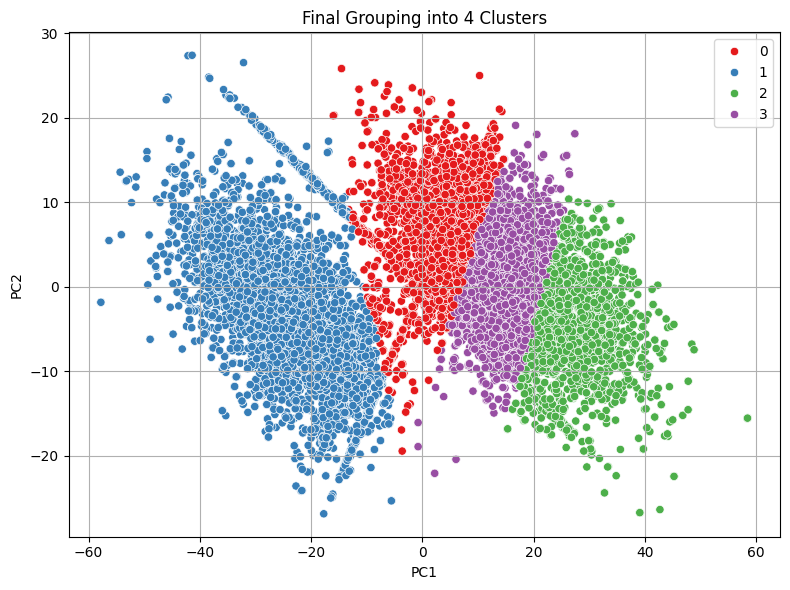

In [104]:
labels, full_data = run_full_fcm_knn_pipeline(
    base_dir="dane",
    folder="duze",
    k=10,                 # Use 10-nearest neighbors for KNN
    fcm_clusters=6,       # Use 6 FCM clusters
    final_clusters=4,     # Final grouping into 4 global clusters
    mask_ratio=0.15,      # Mask 15% of values before imputation
    verbose=True,         # Print cluster output
    visualize=True        # Show PCA plots
)


In [105]:
def benchmark_fcm_knn_pipeline_over_k_multi_seed(
    ks: list[int] = list(range(1, 11)),
    seeds: list[int] = [101, 202, 303],
    folder: str = "duze",
    fcm_clusters: int = 8,
    final_clusters: int = 5,
    mask_ratio: float = 0.1
):
    """
    Benchmarks run_full_fcm_knn_pipeline for multiple k values and seeds.
    Shows one final bar chart with average execution times.
    """
    results = []
    all_std = []

    for k in ks:
        durations = []

        for seed in seeds:
            print(f"Running FCM+KNN pipeline (k={k}, seed={seed})...")
            start = time.perf_counter()
            run_full_fcm_knn_pipeline(
                base_dir="dane",
                folder=folder,
                k=k,
                fcm_clusters=fcm_clusters,
                final_clusters=final_clusters,
                mask_ratio=mask_ratio,
                verbose=False,
                visualize=False  # suppress plots here
            )
            end = time.perf_counter()
            durations.append(end - start)

        avg_time = np.mean(durations)
        std_dev = np.std(durations)
        results.append(avg_time)
        all_std.append(std_dev)
        print(f"k = {k}: avg = {avg_time:.2f}s, std = {std_dev:.2f}s")

    # # Final single plot
    # plt.figure(figsize=(10, 6))
    # plt.bar(ks, results, yerr=all_std, capsize=5, alpha=0.8)
    # plt.title("FCM + KNN Pipeline: Avg Execution Time vs k (3 Seeds)")
    # plt.xlabel("Number of Neighbors (k)")
    # plt.ylabel("Average Time (seconds)")
    # plt.grid(axis='y')
    # plt.tight_layout()
    # plt.show()

    return list(zip(ks, results, all_std))


== Benchmarking with 3 FCM clusters ==
Running FCM+KNN pipeline (k=1, seed=101)...
Filling remaining NaNs with column means before clustering...
Running FCM+KNN pipeline (k=1, seed=202)...
Filling remaining NaNs with column means before clustering...
Running FCM+KNN pipeline (k=1, seed=303)...
Filling remaining NaNs with column means before clustering...
k = 1: avg = 0.60s, std = 0.03s
Running FCM+KNN pipeline (k=2, seed=101)...
Filling remaining NaNs with column means before clustering...
Running FCM+KNN pipeline (k=2, seed=202)...
Filling remaining NaNs with column means before clustering...
Running FCM+KNN pipeline (k=2, seed=303)...
Filling remaining NaNs with column means before clustering...
k = 2: avg = 0.58s, std = 0.01s
Running FCM+KNN pipeline (k=3, seed=101)...
Filling remaining NaNs with column means before clustering...
Running FCM+KNN pipeline (k=3, seed=202)...
Filling remaining NaNs with column means before clustering...
Running FCM+KNN pipeline (k=3, seed=303)...
Fill

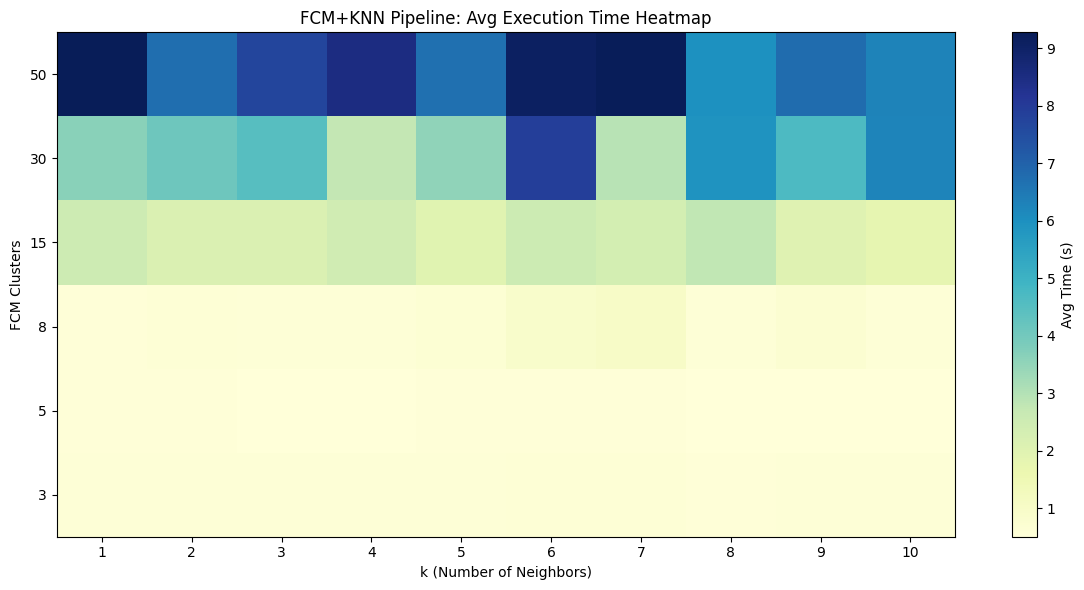

In [106]:
def benchmark_fcm_knn_grid_using_existing_k_benchmark(
    ks: list[int] = list(range(1, 11)),
    cluster_counts: list[int] = [3,5,8,15,30,50],
    seeds: list[int] = [101, 202, 303],
    folder: str = "duze",
    final_clusters: int = 5,
    mask_ratio: float = 0.1
):
    """
    Runs the original k-wise benchmark for each fcm_cluster value,
    building a time grid without rewriting the core logic.
    """
    time_matrix = np.zeros((len(cluster_counts), len(ks)), dtype=float)

    for i, fcm_clusters in enumerate(cluster_counts):
        print(f"\n== Benchmarking with {fcm_clusters} FCM clusters ==")

        # Reuse your original function with a new fcm_clusters value
        results = benchmark_fcm_knn_pipeline_over_k_multi_seed(
            ks=ks,
            seeds=seeds,
            folder=folder,
            fcm_clusters=fcm_clusters,
            final_clusters=final_clusters,
            mask_ratio=mask_ratio
        )

        # Unpack only the avg times
        for j, (_, avg_time, _) in enumerate(results):
            time_matrix[i, j] = avg_time

    # Plot heatmap
    plt.figure(figsize=(12, 6))
    im = plt.imshow(time_matrix, cmap="YlGnBu", aspect="auto", origin="lower")

    plt.xticks(ticks=np.arange(len(ks)), labels=[str(k) for k in ks])
    plt.yticks(ticks=np.arange(len(cluster_counts)), labels=[str(c) for c in cluster_counts])
    plt.xlabel("k (Number of Neighbors)")
    plt.ylabel("FCM Clusters")
    plt.title("FCM+KNN Pipeline: Avg Execution Time Heatmap")
    plt.colorbar(im, label="Avg Time (s)")
    plt.tight_layout()
    plt.show()

    return time_matrix, ks, cluster_counts

import warnings
warnings.filterwarnings("ignore")

time_matrix, ks, fcm_clusters = benchmark_fcm_knn_grid_using_existing_k_benchmark()

# Time consumtion

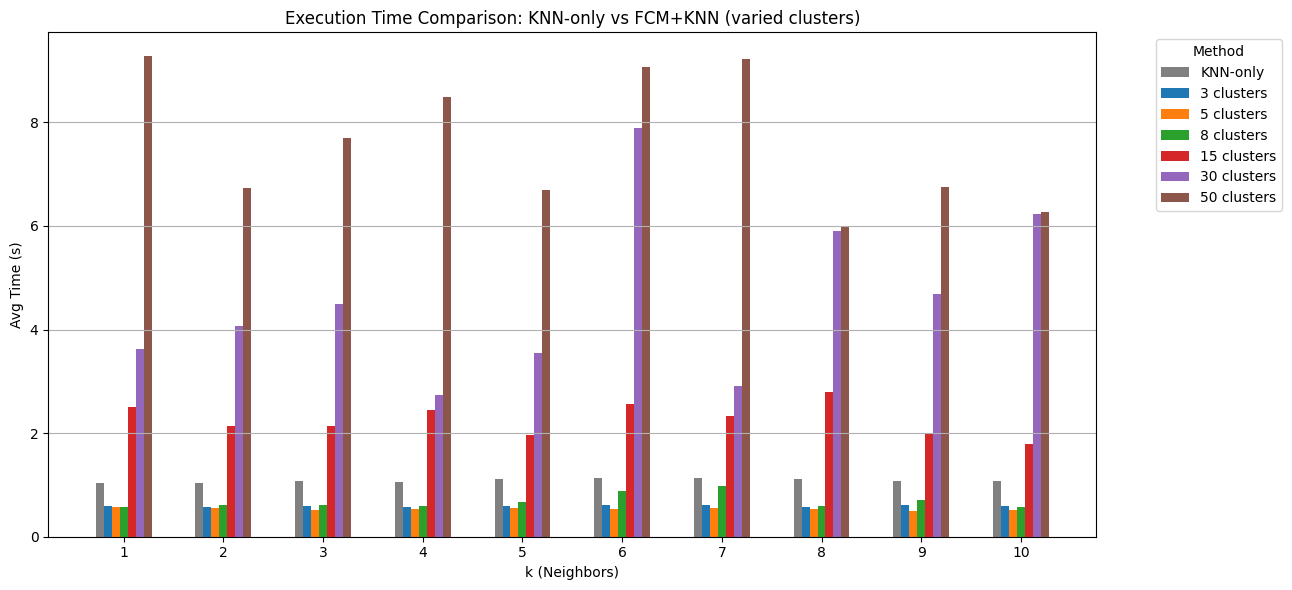

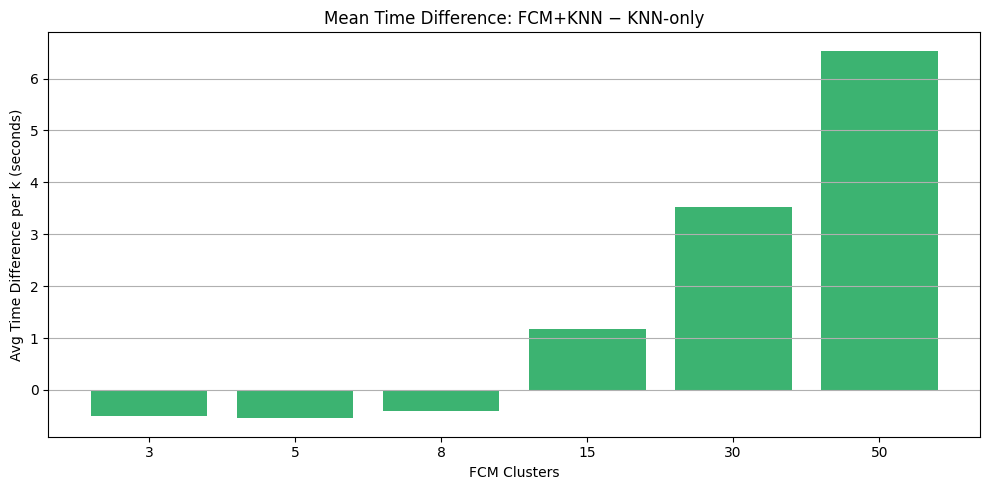

[np.float64(-0.4922788575660282),
 np.float64(-0.5468401716001001),
 np.float64(-0.4023275652005395),
 np.float64(1.1840175546329799),
 np.float64(3.524091837633508),
 np.float64(6.53639113376606)]

In [107]:
def compare_benchmark_results_from_matrix(time_matrix, ks, fcm_clusters, knn_results):
    """
    Compares time_matrix (FCM+KNN) to baseline KNN-only results.
    Plots:
      1. Grouped bar chart of FCM+KNN for each cluster count per k
      2. Sum of (method_2^2 - method_1^2) per cluster count
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # Extract baseline KNN times
    knn_times = [t for _, t, _ in knn_results]
    knn_times = np.array(knn_times)  # shape (len(ks),)

    # Plot 1: Grouped bar chart with KNN-only baseline
    x = np.arange(len(ks))  # positions for k
    width = 0.08
    n = len(fcm_clusters) + 1  # +1 for KNN-only

    plt.figure(figsize=(13, 6))

    # Plot KNN-only first (centered)
    offset_0 = -(n // 2) * width
    plt.bar(x + offset_0, knn_times, width, label="KNN-only", color="gray")

    # Plot each FCM+KNN bar
    for i, cluster_count in enumerate(fcm_clusters):
        offset = (i - n // 2 + 1) * width
        plt.bar(x + offset, time_matrix[i], width, label=f"{cluster_count} clusters")

    plt.xticks(ticks=x, labels=[str(k) for k in ks])
    plt.xlabel("k (Neighbors)")
    plt.ylabel("Avg Time (s)")
    plt.title("Execution Time Comparison: KNN-only vs FCM+KNN (varied clusters)")
    plt.legend(title="Method", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()


    # Plot 2: Mean difference per FCM cluster count
    diff_means = []
    for i in range(len(fcm_clusters)):
        method_2 = np.abs(time_matrix[i])
        method_1 = np.abs(knn_times)
        diff_mean = np.mean(method_2 - method_1)
        diff_means.append(diff_mean)

    plt.figure(figsize=(10, 5))
    plt.bar([str(c) for c in fcm_clusters], diff_means, color="mediumseagreen")
    plt.title("Mean Time Difference: FCM+KNN − KNN-only")
    plt.xlabel("FCM Clusters")
    plt.ylabel("Avg Time Difference per k (seconds)")
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()


    return diff_means


compare_benchmark_results_from_matrix(time_matrix, ks, fcm_clusters, knn_results)


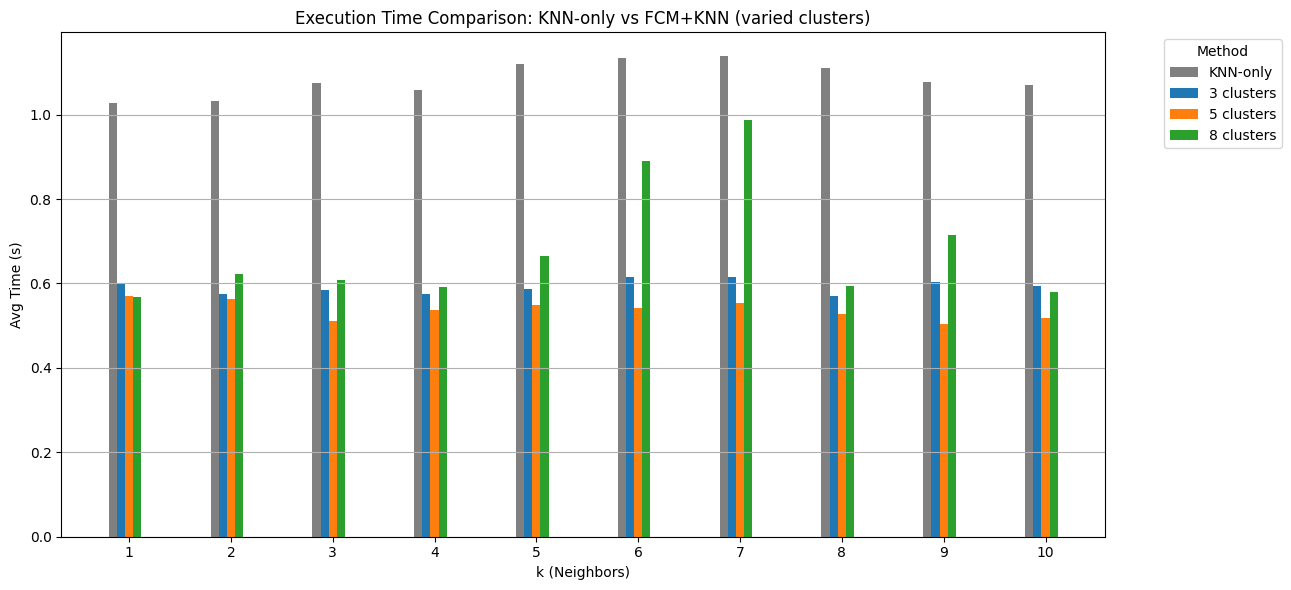

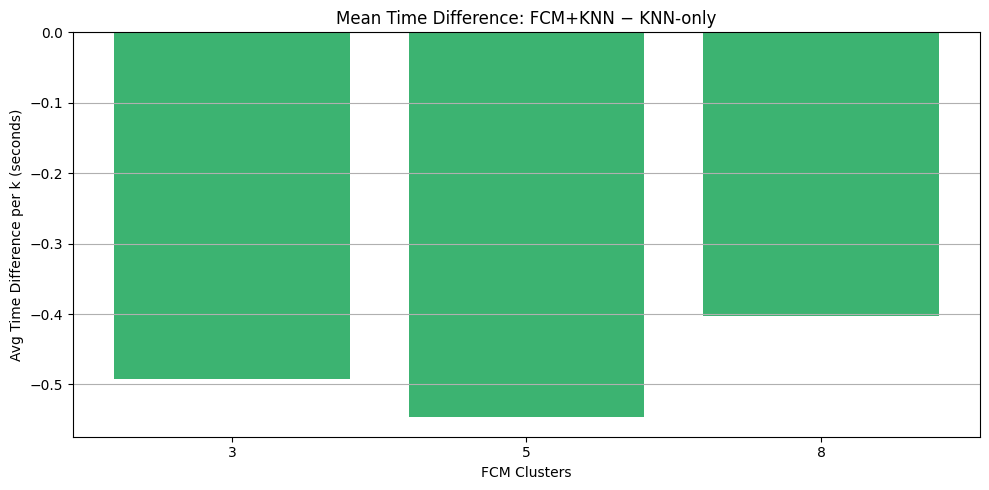

[np.float64(-0.4922788575660282),
 np.float64(-0.5468401716001001),
 np.float64(-0.4023275652005395)]

In [108]:
# Filter to only FCM cluster counts ≤ 10
filtered_indices = [i for i, c in enumerate(fcm_clusters) if c <= 10]
filtered_time_matrix = time_matrix[filtered_indices]
filtered_fcm_clusters = [fcm_clusters[i] for i in filtered_indices]

# Re-compare and plot
compare_benchmark_results_from_matrix(
    filtered_time_matrix,
    ks,
    filtered_fcm_clusters,
    knn_results
)

# Validation of results

In [109]:
def combine_all_folder_data(base_dir: str, folder: str):
    """
    Loads and merges all datasets from a given folder,
    aligning them into one unified attribute space.

    Returns:
        full_matrix: np.ndarray, shape (total_samples, total_attributes)
        global_attrs: list of all unique attribute names
        global_attr_idx: mapping from attribute name to global column index
    """
    all_data_blocks = []
    all_attr_sets = []

    # First pass: collect all attribute sets
    for _, _, attrs in load_folder_data(base_dir, folder):
        all_attr_sets.append(set(attrs))

    global_attrs = sorted(set.union(*all_attr_sets), key=lambda x: int(x))
    global_attr_idx = {attr: i for i, attr in enumerate(global_attrs)}

    # Second pass: load and align data
    for subfolder, full_data_list, attrs in load_folder_data(base_dir, folder):
        local_attr_idx = {attr: i for i, attr in enumerate(attrs)}

        try:
            local_data = np.array([
                [float(value) for value in line]
                for line in full_data_list
            ])
        except Exception as e:
            print(f"Error reading data in subfolder '{subfolder}': {e}")
            continue

        aligned = np.full((len(local_data), len(global_attrs)), np.nan)

        for attr in attrs:
            g_idx = global_attr_idx[attr]
            l_idx = local_attr_idx[attr]

            if l_idx >= local_data.shape[1]:
                print(f"Skipping attribute '{attr}' in '{subfolder}': index {l_idx} out of bounds for data with {local_data.shape[1]} columns")
                continue

            aligned[:, g_idx] = local_data[:, l_idx]

        all_data_blocks.append(aligned)

    if not all_data_blocks:
        raise ValueError(f"No valid data found in folder '{base_dir}/{folder}'")

    full_matrix = np.vstack(all_data_blocks)
    return full_matrix, global_attrs, global_attr_idx

Skipping attribute '14' in '1': index 8 out of bounds for data with 8 columns
Skipping attribute '14' in '2': index 8 out of bounds for data with 8 columns
Mean Absolute Error (KNN-only):     1.9145
Mean Absolute Error (FCM + KNN):    2.8019


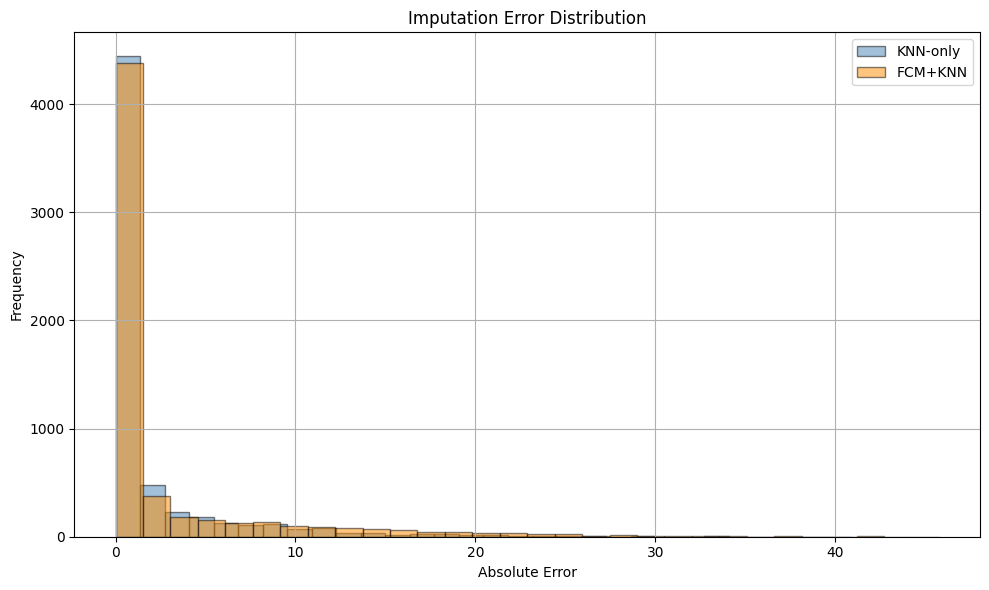

In [ ]:
# Combine all datasets
base_dir = "dane"
folder = "duze"
full_data, all_attrs, attr_idx = combine_all_folder_data(base_dir, folder)

# print("original shape:    ", original.shape)
# print("masked shape:      ", masked.shape)
# print("knn_filled shape:  ", knn_filled.shape)
# print("fcm_filled shape:  ", fcm_filled.shape)

# Track which values were masked
mask = np.isnan(masked) & ~np.isnan(original)
knn_errors = np.abs(knn_filled[mask] - original[mask])
fcm_errors = np.abs(fcm_filled[mask] - original[mask])

# Metrics
mae_knn = np.mean(knn_errors)
mae_fcm = np.mean(fcm_errors)

print(f"Mean Absolute Error (KNN-only):     {mae_knn:.4f}")
print(f"Mean Absolute Error (FCM + KNN):    {mae_fcm:.4f}")

# Compute histograms (same bins for both)
bins = np.linspace(0, max(knn_errors.max(), fcm_errors.max()), 30)
knn_hist, _ = np.histogram(knn_errors, bins=bins)
fcm_hist, _ = np.histogram(fcm_errors, bins=bins)

# Bin centers
bin_centers = 0.5 * (bins[:-1] + bins[1:])
bar_width = (bins[1] - bins[0]) * 0.4  # 40% of bin width

# Plot side-by-side bars
plt.figure(figsize=(10, 6))
plt.bar(bin_centers - bar_width/2, knn_hist, width=bar_width, label='KNN-only', color='steelblue', edgecolor='black')
plt.bar(bin_centers + bar_width/2, fcm_hist, width=bar_width, label='FCM+KNN', color='darkorange', edgecolor='black')

# Labels and styling
plt.title("Imputation Error Distribution (Side-by-Side)")
plt.xlabel("Absolute Error")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
